# Simulation on Power System State Estimation and FDI Attacks

In [37]:
# Import packages
from pypower.api import *
from mea_idx import define_mea_idx_noise
from se_config import se_config
from run_AC_SE import SE
from fdi_att import FDI

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# OPF Options
opt = ppoption()              # OPF options
opt['VERBOSE'] = 0
opt['OUT_ALL'] = 0
opt['OPF_FLOW_LIM'] = 1       # Constraint on the active power flow

## Power System State Estimation (PSSE)
We consider different types and amount of measurements in the AC-PSSE. In the first case study, the entire measurement from both RTUs and PMUs are considered which includes.
1. "From" side active power flow: pf;
2. "To" side active power flow: pt;
3. Active power injection: pi;
4. Voltage angle: vang;
5. "From" side reactive power flow: qf;
6. "To" side reactive power flow: qt;
7. Reactive power injection: qi;
8. Voltage magnitude: vmag;

In this case, we set the FPR of BDD as 0.02, e.g. ~2% of the normal measurement can be detected as suspicious

In [20]:
# Generate a basic case
case = case14()
# Determine the measurement, here we can the default "full" setting
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'full')

#print(idx)           # Define the type and index of each measurement
#print(no_mea)        # The total No. of measurement
#print(noise_sigma)   # Define the std of measurement noise on each measurement

# Instance the state estimation Class SE
se = SE(case, noise_sigma=noise_sigma, idx=mea_idx, fpr = 0.02)

# Run opf to get the measurement
result = runopf(case, opt)

# Construct the measurement
z, z_noise, vang_ref, vmag_ref = se.construct_mea(result) # Get the measurement

# Run AC-SE
se_config['verbose'] = 1  # Default is 0
v_est = se.ac_se_pypower(z_noise, vang_ref, vmag_ref, config = se_config)

# BDD detection
residual = se.bdd_residual(z_noise, vang_ref, vmag_ref)
print(f'BDD threshold: {se.bdd_threshold}')
print(f'residual: {residual}')

iteration 1 norm of mismatch: 3036877.214173
iteration 2 norm of mismatch: 128454.648333
iteration 3 norm of mismatch: 133.309134
iteration 4 norm of mismatch: 0.019825
iteration 5 norm of mismatch: 7e-06
BDD threshold: 142.56166130478624
residual: 102.4224074888734


We can even run more state estimations to see the residual distributions. Note that we only run under the same load condition (Note: it may take a while for different test size.)

The true positive rate: 0.017


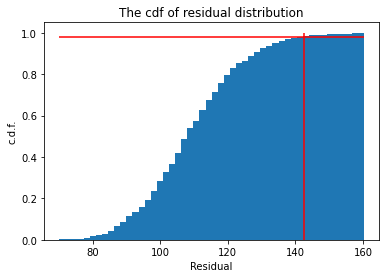

In [27]:
r_summary = []
for _ in range(1000):
    # Generate different noisy measurement
    z, z_noise, vang_ref, vmag_ref = se.construct_mea(result)
    residual = se.bdd_residual(z_noise, vang_ref, vmag_ref)
    r_summary.append(residual)

fp_no = 0
for residual in r_summary:
    if residual >= se.bdd_threshold:
        fp_no += 1

fpr = fp_no/len(r_summary)
print(f'The false positive rate: {fpr}')   # close to fpr = 0.02
ax = plt.figure()
plt.hist(r_summary, cumulative=True, density=True, bins=50)
plt.vlines(ymin=0, ymax=1, x=se.bdd_threshold, colors='red')
plt.xlabel('Residual')
plt.ylabel('c.d.f.')
plt.title('The cdf of residual distribution')
plt.hlines(xmin=np.min(r_summary),xmax=np.max(r_summary), y=0.98, colors='red')
plt.show()

## False Data Injection (FDI)

### Attack on single phase angle

The pv and pq bus include [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


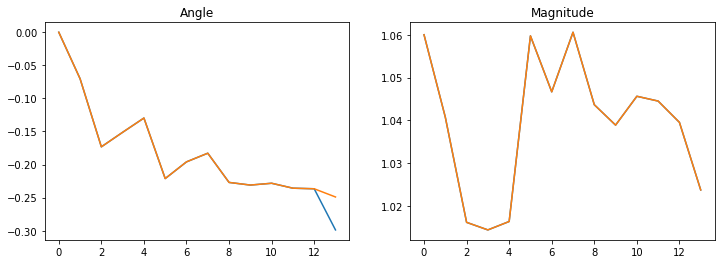

In [68]:
# Instance the Class FDI
fdi = FDI(case, noise_sigma, mea_idx, 0.02)
# Specify the attack type
att_spec = {}
print(f'The pv and pq bus include {fdi.non_ref_index}')
att_spec['ang_posi'] = random.sample(fdi.non_ref_index, 1)
att_spec['ang_str'] = 0.2
att_spec['mag_posi'] = []
att_spec['mag_str'] = 0
# Do state estimation
v_est = fdi.ac_se_pypower(z_noise, vang_ref, vmag_ref)
# Generate FDI attack
v_att = fdi.gen_att(v_est, att_spec)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.angle(v_att), label = 'att ang')
ax1.plot(np.angle(v_est), label = 'est ang')
ax2.plot(np.abs(v_att), label = 'att ang')
ax2.plot(np.abs(v_est), label = 'est ang')
ax1.title.set_text('Angle')
ax2.title.set_text('Magnitude')

Test on the BDD detection result on the FDI attacks. It should give the residual smaller than the BDD threshold.

In [69]:
# Calculate the attacked measurement
z_att_est = fdi.h_x_pypower(v_att)
z_est = fdi.h_x_pypower(v_est)
z_att_noise = z_noise + z_att_est - z_est
# Find the detection residual
residual_att = fdi.bdd_residual(z_att_noise, vang_ref, vmag_ref)
print(f'BDD threshold: {se.bdd_threshold}')
print(f'residual: {residual_att}')

BDD threshold: 142.56166130478624
residual: 102.62756575535616


Test more on the random attack (which may take a while):

The true positive rate: 0.018


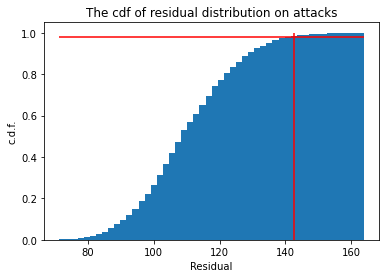

In [75]:
r_summary_att = []
for _ in range(1000):
    # Generate different noisy measurement
    z, z_noise, vang_ref, vmag_ref = se.construct_mea(result)
    # Specify the attack type
    att_spec = {}
    ang_no = np.random.randint(fdi.no_bus-1)
    att_spec['ang_posi'] = random.sample(fdi.non_ref_index, ang_no)
    att_spec['ang_str'] = -0.5+np.random.rand()        #-0.5-0.4
    mag_no = np.random.randint(fdi.no_bus-1)
    att_spec['mag_posi'] = random.sample(fdi.non_ref_index, mag_no)
    att_spec['mag_str'] = -0.1+0.2*np.random.rand()    # -0.1-0.1
    
    # Do state estimation
    v_est = fdi.ac_se_pypower(z_noise, vang_ref, vmag_ref)
    # Generate FDI attack
    v_att = fdi.gen_att(v_est, att_spec)
    
    # Calculate the attacked measurement
    z_att_est = fdi.h_x_pypower(v_att)
    z_est = fdi.h_x_pypower(v_est)
    z_att_noise = z_noise + z_att_est - z_est
    # Find the detection residual
    residual_att = fdi.bdd_residual(z_att_noise, vang_ref, vmag_ref)
    r_summary_att.append(residual_att)

tp_no = 0
for residual in r_summary_att:
    if residual >= se.bdd_threshold:
        tp_no += 1

tpr = tp_no/len(r_summary_att)
print(f'The true positive rate: {tpr}')   # close to fpr = 0.02
ax = plt.figure()
plt.hist(r_summary_att, cumulative=True, density=True, bins=50)
plt.vlines(ymin=0, ymax=1, x=fdi.bdd_threshold, colors='red')
plt.xlabel('Residual')
plt.ylabel('c.d.f.')
plt.title('The cdf of residual distribution on attacks')
plt.hlines(xmin=np.min(r_summary_att),xmax=np.max(r_summary_att), y=0.98, colors='red')
plt.show()

# RTU Measurement Case
In this case, only RTU measurements are considered: e.g. no vang from the full measurement case
1. "From" side active power flow: pf;
2. "To" side active power flow: pt;
3. Active power injection: pi;
4. "From" side reactive power flow: qf;
5. "To" side reactive power flow: qt;
6. Reactive power injection: qi;
7. Voltage magnitude: vmag;

In [53]:
case = case14()
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'RTU')
print(f'mea_idx: \n{mea_idx}')
se = SE(case, noise_sigma=noise_sigma, idx=mea_idx)
se.no_mea
result = runopf(case, opt)
z, z_noise, vang_ref, vmag_ref = se.construct_mea(result) # Get the measurement
print(f'measurement shape: \n{z_noise.shape}')
se_config['verbose'] = 1  # Default is 0
se.ac_se_pypower(z_noise, vang_ref, vmag_ref, config = se_config)


mea_idx: 
{'pf': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'pt': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'pi': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'vang': [], 'qf': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'qt': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'qi': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'vmag': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])}
measurement shape: 
(122, 1)
iteration 1 norm of mismatch: 3035043.110315
iteration 2 norm of mismatch: 133299.563165
iteration 3 norm of mismatch: 209.286228
iteration 4 norm of mismatch: 0.069424
iteration 5 norm of mismatch: 4e-05
iteration 6 norm of mismatch: 0.0


# Half RTU Measurement 
In this case, only from side and injection RTU measurements are considered
1. "From" side active power flow: pf;
2. Active power injection: pi;
3. "From" side reactive power flow: qf;
4. Reactive power injection: qi;

In [54]:
case = case14()
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'HALF_RTU')
print(f'mea_idx: \n{mea_idx}')
se = SE(case, noise_sigma=noise_sigma, idx=mea_idx)
se.no_mea
result = runopf(case, opt)
z, z_noise, vang_ref, vmag_ref = se.construct_mea(result) # Get the measurement
print(f'measurement shape: \n{z_noise.shape}')
se_config['verbose'] = 1  # Default is 0
se.ac_se_pypower(z_noise, vang_ref, vmag_ref, config = se_config)

mea_idx: 
{'pf': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'pt': [], 'pi': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'vang': [], 'qf': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'qt': [], 'qi': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'vmag': []}
measurement shape: 
(68, 1)
iteration 1 norm of mismatch: 2525931.608909
iteration 2 norm of mismatch: 98809.035439
iteration 3 norm of mismatch: 1294.335789
iteration 4 norm of mismatch: 0.253333
iteration 5 norm of mismatch: 8.3e-05
iteration 6 norm of mismatch: 0.0


# A Random case
Each measurement type is randomly picked

In [69]:
case = case14()
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'RANDOM')
print(f'mea_idx: \n{mea_idx}')
se = SE(case, noise_sigma=noise_sigma, idx=mea_idx)
se.no_mea
result = runopf(case, opt)
z, z_noise, vang_ref, vmag_ref = se.construct_mea(result) # Get the measurement
print(f'measurement shape: \n{z_noise.shape}')
se_config['verbose'] = 1  # Default is 0
se.ac_se_pypower(z_noise, vang_ref, vmag_ref, config = se_config)

mea_idx: 
{'pf': [2, 19, 0, 16], 'pt': [13, 8, 14, 9, 18], 'pi': [4, 3, 7, 8, 2, 13, 9, 12, 5, 11, 10, 0, 1], 'vang': [9, 11, 10, 4], 'qf': [9, 10, 19, 7, 2, 15, 16, 18, 11, 3, 1, 5, 17, 6, 0], 'qt': [12, 15, 2, 18, 14], 'qi': [6, 11, 4, 9, 1, 10, 12, 3, 5, 13], 'vmag': []}
measurement shape: 
(56, 1)
iteration 1 norm of mismatch: 1698096.116397
iteration 2 norm of mismatch: 136806.549409
iteration 3 norm of mismatch: 980.893884
iteration 4 norm of mismatch: 0.20833
iteration 5 norm of mismatch: 9.1e-05
iteration 6 norm of mismatch: 0.0


# A Random Case which likely gives unobservability

In [74]:
case = case14()
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'UNOBSERVABLE')
print(f'mea_idx: \n{mea_idx}')
se = SE(case, noise_sigma=noise_sigma, idx=mea_idx)
se.no_mea
result = runopf(case, opt)
z, z_noise, vang_ref, vmag_ref = se.construct_mea(result) # Get the measurement
print(f'measurement shape: \n{z_noise.shape}')
se_config['verbose'] = 1  # Default is 0
se.ac_se_pypower(z_noise, vang_ref, vmag_ref, config = se_config)

mea_idx: 
{'pf': [12, 18, 16], 'pt': [2], 'pi': [4, 11, 6], 'vang': [3, 4, 11, 6, 8, 0, 7, 13], 'qf': [4, 16, 6, 2, 11, 17, 13, 15, 12, 3], 'qt': [1, 11, 3, 7, 5, 14], 'qi': [12, 8], 'vmag': [8, 1, 7, 11, 12, 5, 2, 4]}
measurement shape: 
(41, 1)
The current measurement setting is not observable.
